In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv("data/accidents.csv")

# Get rid of values after 2020
df = df[df.JAHR < 2021].reset_index().drop("index", axis=1)

df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2020,Summe,430.0,434.0,NaN,-0.92,NaN
1,Alkoholunfälle,insgesamt,2020,202001,28.0,22.0,-20.00,27.27,37.0
2,Alkoholunfälle,insgesamt,2020,202002,40.0,28.0,42.86,42.86,38.0
3,Alkoholunfälle,insgesamt,2020,202003,27.0,34.0,-32.50,-20.59,37.0
4,Alkoholunfälle,insgesamt,2020,202004,26.0,36.0,-3.70,-27.78,36.0


# Missing Value Analysis

There are no unexplained missing values.

In [3]:
# Check each column for nulls

na_cols = {}
for col in df.columns:
    empty_rows = df[df[col].isna()]
    if (empty_rows.size >0):
        na_cols[col] = empty_rows.size
        
print(na_cols)

{'VORJAHRESWERT': 819, 'VERAEND_VORMONAT_PROZENT': 1395, 'VERAEND_VORJAHRESMONAT_PROZENT': 828, 'ZWOELF_MONATE_MITTELWERT': 1323}


In [4]:
# Analyse NA values

# VORJAHRESWERT
print(df[df.VORJAHRESWERT.isna()].JAHR.unique()) # all values from 2000
print(df.JAHR.min()) # because 2000 is the first year on record

# VERAEND_VORMONAT_PROZENT
print("---------------------------------------------------------------------------------")
print(df[df.VERAEND_VORMONAT_PROZENT.isna()].MONAT.unique())
# Logical for yearly sum
# Jan. 2020 first month on record
# 2013/02 had no injured
print(df[((df.MONAT == "201303") | (df.MONAT == "201302")) & (df.AUSPRAEGUNG == "Verletzte und Getötete")& (df.MONATSZAHL == "Alkoholunfälle")])

# VERAEND_VORJAHRESMONAT_PROZENT
print("---------------------------------------------------------------------------------")
print(df[df.VERAEND_VORJAHRESMONAT_PROZENT.isna()].MONAT.unique())
# 2020 first year on record
# 2013/02 had no injured

# ZWOELF_MONATE_MITTELWERT
print("---------------------------------------------------------------------------------")
df[df.ZWOELF_MONATE_MITTELWERT.isna()].MONAT.unique() # Only for sum rows

[2000]
2000
---------------------------------------------------------------------------------
['Summe' '200001' '201303']
         MONATSZAHL             AUSPRAEGUNG  JAHR   MONAT  WERT  \
366  Alkoholunfälle  Verletzte und Getötete  2013  201302   0.0   
367  Alkoholunfälle  Verletzte und Getötete  2013  201303   8.0   

     VORJAHRESWERT  VERAEND_VORMONAT_PROZENT  VERAEND_VORJAHRESMONAT_PROZENT  \
366            5.0                    -100.0                          -100.0   
367            5.0                       NaN                            60.0   

     ZWOELF_MONATE_MITTELWERT  
366                      17.0  
367                      18.0  
---------------------------------------------------------------------------------
['Summe' '200001' '200002' '200003' '200004' '200005' '200006' '200007'
 '200008' '200009' '200010' '200011' '200012' '201402']
---------------------------------------------------------------------------------


array(['Summe'], dtype=object)

# Tidy Data

In [5]:
def convert_months(digits):
    months = {
        "01": "January",
        "02": "February",
        "03": "March",
        "04": "April",
        "05": "May",
        "06": "June",
        "07": "July",
        "08": "August",
        "09": "September",
        "10": "October",
        "11": "November",
        "12": "December"
    }
    
    if(digits != "Summe"):
        return months[digits[-2:]]
    return digits

# Add a column with the month names in english
df["MONAT_EN"] = df["MONAT"].apply(convert_months)

df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT,MONAT_EN
0,Alkoholunfälle,insgesamt,2020,Summe,430.0,434.0,NaN,-0.92,NaN,Summe
1,Alkoholunfälle,insgesamt,2020,202001,28.0,22.0,-20.00,27.27,37.0,January
2,Alkoholunfälle,insgesamt,2020,202002,40.0,28.0,42.86,42.86,38.0,February
3,Alkoholunfälle,insgesamt,2020,202003,27.0,34.0,-32.50,-20.59,37.0,March
4,Alkoholunfälle,insgesamt,2020,202004,26.0,36.0,-3.70,-27.78,36.0,April


# Outlier Analysis

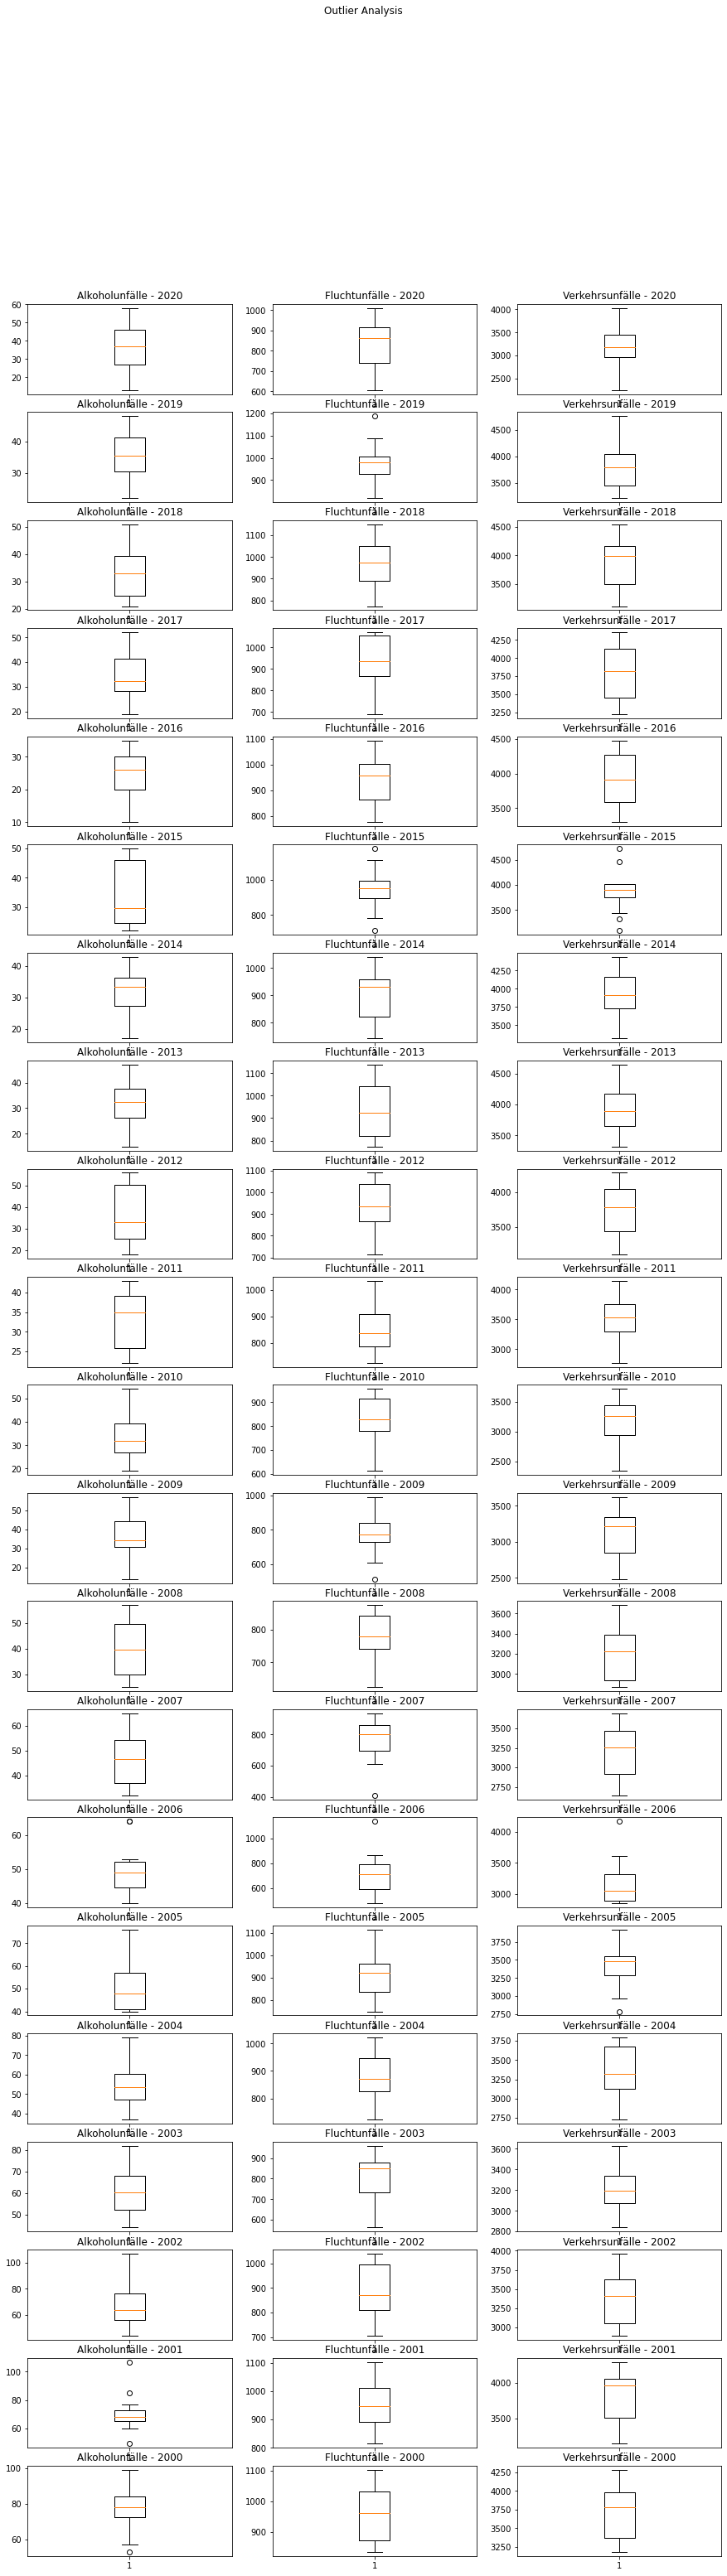

In [6]:
years = df.JAHR.unique()
types = df.MONATSZAHL.unique()

fig, ax = plt.subplots(nrows=len(years), ncols=len(types), figsize=(15,50))
fig.suptitle("Outlier Analysis")

for i in range(len(years)):
    for j in range(len(types)):
        ax[i,j].boxplot("WERT", data=df[(df.AUSPRAEGUNG == "insgesamt") & (df.MONAT != "Summe") & (df.MONATSZAHL == types[j]) & (df.JAHR == years[i])])
        title = types[j] + " - " + str(years[i])
        ax[i,j].set_title(title)

Upon analysis of the outliers, we can see that:
1. There aren't too many outliers to worry about
2. The difference from the median, in case of an outlier, is never too unrealistic

We can, therefore, move forward without any further treatment of these values necessary

# Visualisation

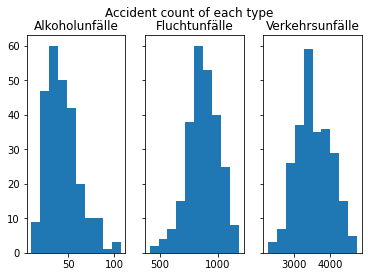

In [7]:
fig, ax = plt.subplots(1, len(types), sharey=True)
fig.suptitle("Accident count of each type")

for i in range(len(types)):
    ax[i].hist("WERT", data=df[(df.MONAT != "Summe") & (df.MONATSZAHL == types[i]) & (df.AUSPRAEGUNG == "insgesamt")])
    ax[i].set_title(types[i])

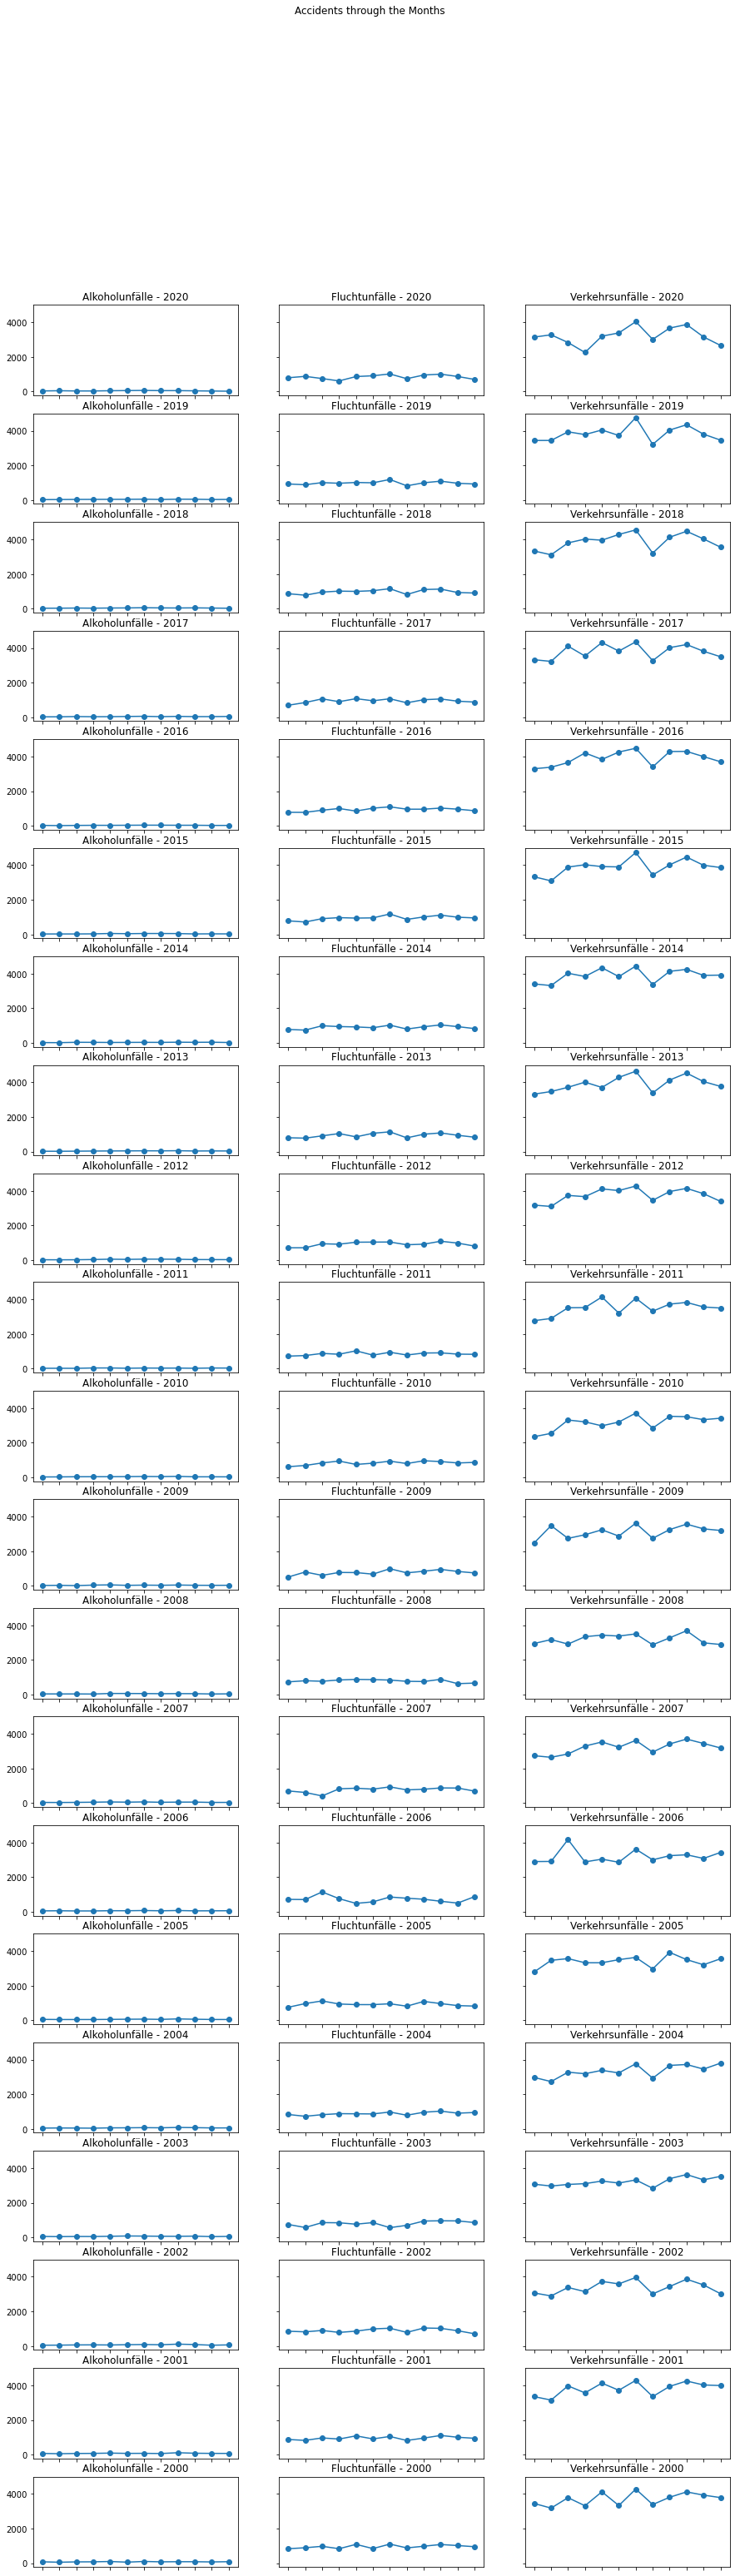

In [8]:
fig, ax = plt.subplots(nrows=len(years), ncols=len(types), figsize=(15,50), sharey=True)
fig.suptitle("Accidents through the Months")

for i in range(len(years)):
    for j in range(len(types)):
        ax[i,j].plot("MONAT_EN", "WERT", '-o', data=df[(df.AUSPRAEGUNG == "insgesamt") & (df.MONAT != "Summe") & (df.MONATSZAHL == types[j]) & (df.JAHR == years[i])])
        title = types[j] + " - " + str(years[i])
        ax[i,j].set_title(title)
        ax[i,j].set_xticklabels([])

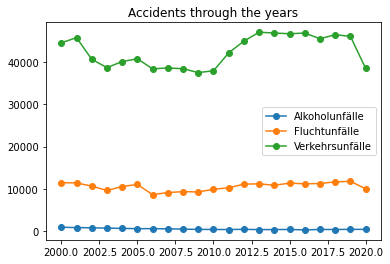

In [9]:
plt.title("Accidents through the years")

for typ in types:
    plt.plot("JAHR", "WERT", '-o', data=df[(df.AUSPRAEGUNG == "insgesamt") & (df.MONAT == "Summe") & (df.MONATSZAHL == typ)], label=typ)
    
plt.legend()
plt.show()

# Build the Model

## Linear Regression

In [3]:
# Build feature set
df_features = df[(df.MONAT != "Summe") & (df.AUSPRAEGUNG == "insgesamt") & (df.MONATSZAHL == "Alkoholunfälle")][["MONAT", "WERT"]]
df_features.head()

,MONAT,WERT
1,202001,28.0
2,202002,40.0
3,202003,27.0
4,202004,26.0
5,202005,40.0


In [4]:
X = df_features.MONAT.values.reshape(-1, 1)
y = df_features.WERT.values.reshape(-1, 1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)

In [5]:
df_features["Linear Prediction"] = y_pred.reshape(-1)
df_features.head()

,MONAT,WERT,Linear Prediction
1,202001,28.0,23.46616
2,202002,40.0,23.44576
3,202003,27.0,23.42536
4,202004,26.0,23.40496
5,202005,40.0,23.38456


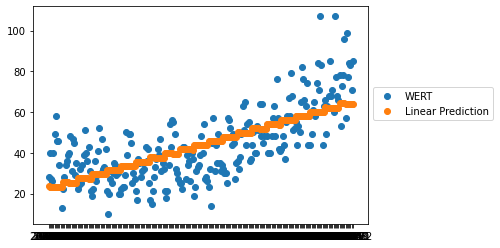

In [6]:
plt.plot("MONAT", "WERT", "o", data=df_features)
plt.plot("MONAT", "Linear Prediction", "o", data=df_features)
plt.legend(bbox_to_anchor=(1, .65))
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print("Linear Regression R2 Score:", linear_model.score(X,y))
print("Linear Regression MSE:", mean_squared_error(y, y_pred))
print("Linear Regression MAE:", mean_absolute_error(y, y_pred))
print("Linear Regression MAPE:", mean_absolute_percentage_error(y, y_pred))

Linear Regression R2 Score: 0.46922727710221923
Linear Regression MSE: 172.61223079452435
Linear Regression MAE: 10.54779982283996
Linear Regression MAPE: 0.2913832685844446


In [8]:
print("Prediction for Alkoholunfälle in Jan. 2021:", linear_model.predict(np.asarray([202101]).reshape(1, -1))[0][0])

Prediction for Alkoholunfälle in Jan. 2021: 21.42615950299023


# Save Model

In [9]:
import pickle

filename = 'linear_model.pkl'
pickle.dump(linear_model, open(filename, 'wb'))